In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [3]:
pjme = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Measles/nigeria.csv', index_col=[0], parse_dates=[0])

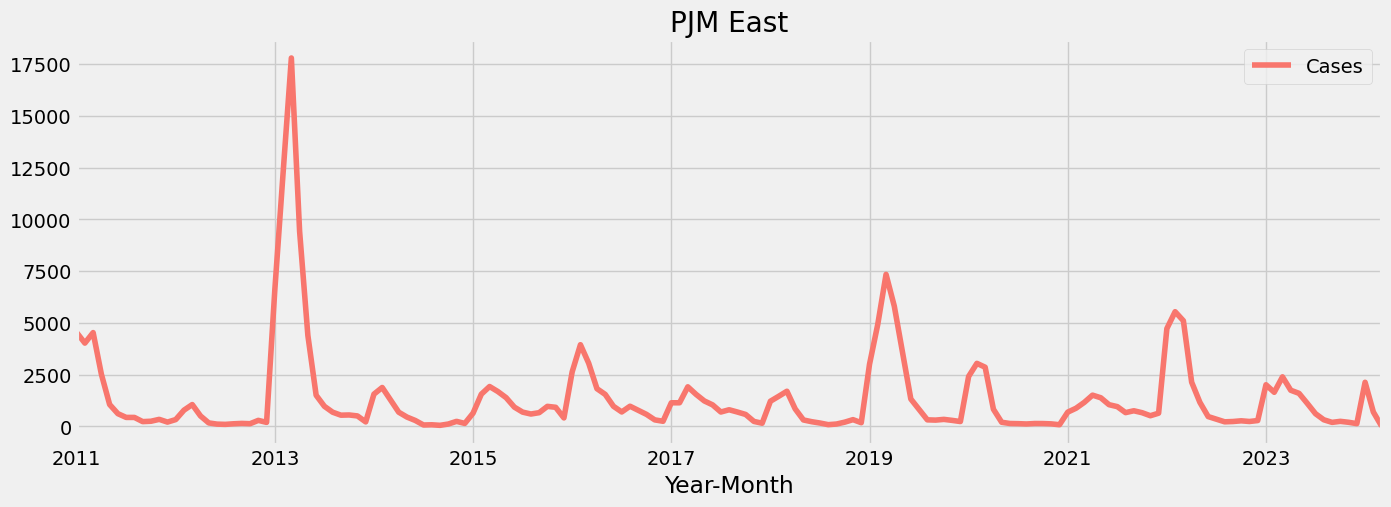

In [4]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(figsize=(15,5), color=color_pal[0], title='PJM East')

In [5]:
split_date = '01-March-2023'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

In [6]:
len(pjme_test)

12

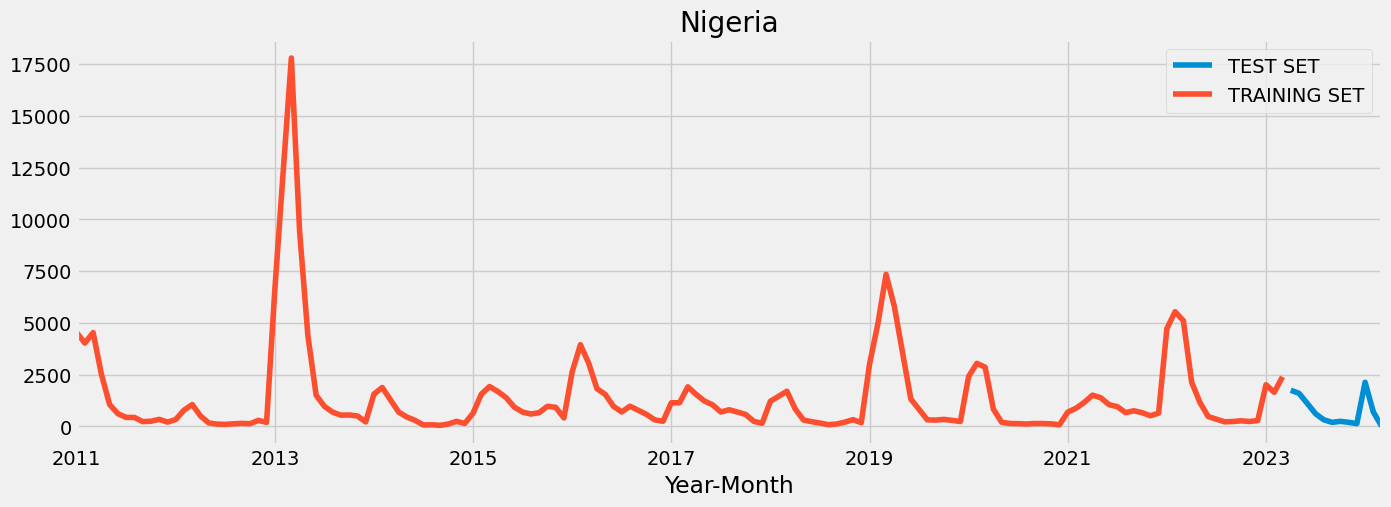

In [7]:
_ = pjme_test \
    .rename(columns={'Cases': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'Cases': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Nigeria')

In [8]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day

    X = df[['month','year','dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

In [9]:
X_train, y_train = create_features(pjme_train, label='Cases')
X_test, y_test = create_features(pjme_test, label='Cases')

In [10]:
reg = xgb.XGBRegressor(n_estimators=17, max_depth=7, eta=1.4, subsample=0.4, colsample_bytree=1)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=20,
       verbose=True) # Change verbose to True if you want to see it train

[0]	validation_0-rmse:1306.93125	validation_1-rmse:1434.54885
[1]	validation_0-rmse:1507.90525	validation_1-rmse:457.38922
[2]	validation_0-rmse:1544.52899	validation_1-rmse:648.03365
[3]	validation_0-rmse:1683.13784	validation_1-rmse:843.94876
[4]	validation_0-rmse:1423.80874	validation_1-rmse:528.56183
[5]	validation_0-rmse:1276.41926	validation_1-rmse:903.11309
[6]	validation_0-rmse:871.04359	validation_1-rmse:632.62906
[7]	validation_0-rmse:1160.61283	validation_1-rmse:671.19131
[8]	validation_0-rmse:1127.86629	validation_1-rmse:1241.26253
[9]	validation_0-rmse:1083.70967	validation_1-rmse:1663.90809
[10]	validation_0-rmse:1029.85084	validation_1-rmse:1701.15898
[11]	validation_0-rmse:650.00405	validation_1-rmse:1608.69979
[12]	validation_0-rmse:520.75471	validation_1-rmse:1556.22842
[13]	validation_0-rmse:541.54363	validation_1-rmse:1541.78948
[14]	validation_0-rmse:477.69927	validation_1-rmse:1764.02741
[15]	validation_0-rmse:376.52631	validation_1-rmse:1754.62891
[16]	validation

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eta=1.4, eval_metric=None, feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=17, n_jobs=None,
             num_parallel_tree=None, ...)

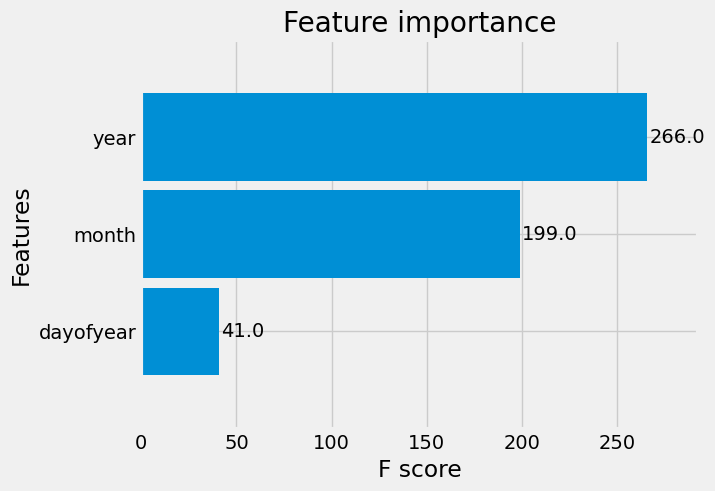

In [11]:
_ = plot_importance(reg, height=0.9)

In [12]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

In [13]:
pjme_test['MW_Prediction']

Year-Month
2023-04-01    1719.857666
2023-05-01    1171.434692
2023-06-01     223.345322
2023-07-01     223.345322
2023-08-01     223.345322
2023-09-01     185.036667
2023-10-01     185.036667
2023-11-01     185.036667
2023-12-01     185.036667
2024-01-01    1821.932373
2024-02-01    1821.932373
2024-03-01      79.092529
Name: MW_Prediction, dtype: float32

In [14]:
from sklearn.metrics import mean_squared_error
error = np.sqrt(mean_squared_error(pjme_test['Cases'],pjme_test['MW_Prediction']))
#print('Test RMSE: %.4f' % error)

def mean_absolute_percentage_error(y_true, y_pred):

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mape = mean_absolute_percentage_error(pjme_test['Cases'],pjme_test['MW_Prediction'])

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(pjme_test['Cases'],pjme_test['MW_Prediction'])
#print("Mean Absolute Error (MAE):", mae)

from sklearn.metrics import mean_squared_log_error
msle = mean_squared_log_error(pjme_test['Cases'],pjme_test['MW_Prediction'])
#print("Mean Squared Logarithmic Error (MSLE):", msle)

from sklearn.metrics import mean_absolute_percentage_error
#print('Mean Absolute Percentage Error (MAPE):',mean_absolute_percentage_error(test_data_pr['y'],prophet_pred['Pred']))

print('RMSE: %.2f' % error)
print(f"MAPE: {mape:.2f}%")
print('MAE:  %.2f' % mae)
print('MSLE: %.2f' % msle)

RMSE: 457.39
MAPE: 84.44%
MAE:  289.22
MSLE: 0.69


In [15]:
# Generate dates for the next 6 months
last_date = pjme.index[-1]  # Get the last date in the dataset
next_dates = pd.date_range(start=last_date, periods=7, freq='M')[1:]  # Generate next 6 months dates

# Create features for the next 6 months
next_features = create_features(pd.DataFrame(index=next_dates))

# Make predictions for the next 6 months
next_predictions = reg.predict(next_features)

# Create a DataFrame for the predictions
future_predictions = pd.DataFrame({
    'Date': next_dates,
    'MW_Prediction': next_predictions
})

future_predictions.set_index('Date', inplace=True)

future_predictions

,MW_Prediction
Date,
2024-04-30,522.210266
2024-05-31,223.345322
2024-06-30,223.345322
2024-07-31,223.345322
2024-08-31,223.345322
2024-09-30,185.036667


In [16]:
asd=pjme_test['Cases']

In [17]:
asd.loc['2024-04-01'] = 522
asd.loc['2024-05-01'] = 223
asd.loc['2024-06-01'] = 223
asd.loc['2024-07-01'] = 223
asd.loc['2024-08-01'] = 223
asd.loc['2024-09-01'] = 185

In [18]:
asd = asd.iloc[12:]

<ipython-input-19-a7ddb7bd8e1a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = pjme_test['MW_Prediction']


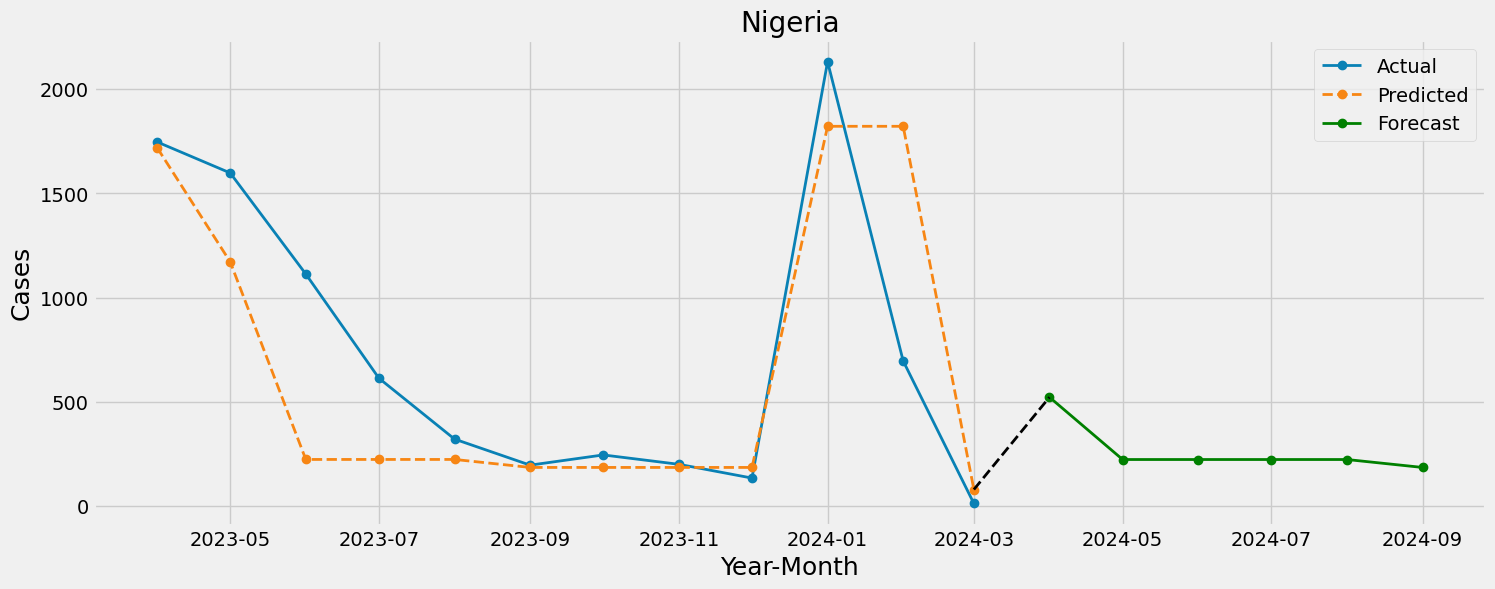

In [19]:
# Plot the data
forecasting = asd
valid = pjme[147:]
valid['Predictions'] = pjme_test['MW_Prediction']
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Nigeria')
plt.xlabel('Year-Month', fontsize=18)
plt.ylabel('Cases', fontsize=18)
plt.plot(valid['Cases'], color='#0981b5', marker='o',linewidth=2)  # Actual cases
plt.plot(valid['Predictions'], color='#f78614',marker='o', linestyle='--',linewidth=2)  # Predicted cases (dashed line)
plt.plot(forecasting, marker='o', color='green',linewidth=2)  # Forecasted cases
plt.plot([valid.index[-1], forecasting.index[0]], [valid['Predictions'].iloc[-1], forecasting.iloc[0]], 'k--',linewidth=2)  # Dashed line connecting predicted and forecast
plt.legend(['Actual', 'Predicted', 'Forecast'], loc='upper right')
plt.show()

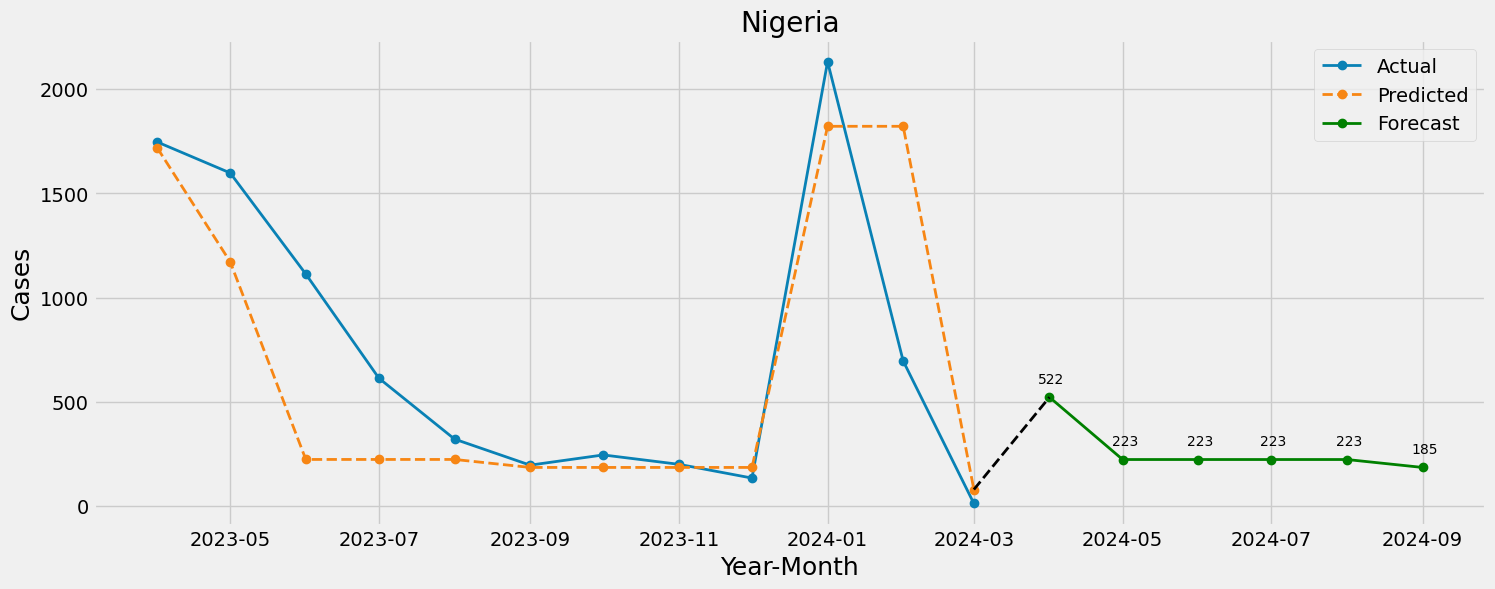

In [20]:
import matplotlib.pyplot as plt

# Assuming 'asd' contains your forecasted values

# Plot the data
plt.figure(figsize=(16, 6))
plt.title('Nigeria')
plt.xlabel('Year-Month', fontsize=18)
plt.ylabel('Cases', fontsize=18)

# Plot actual cases
plt.plot(valid['Cases'], color='#0981b5', marker='o', linewidth=2, label='Actual')

# Plot predicted cases
plt.plot(valid['Predictions'], color='#f78614', marker='o', linestyle='--', linewidth=2, label='Predicted')

# Plot forecasted cases
plt.plot(forecasting.index, forecasting.values, color='green', marker='o', linewidth=2, label='Forecast')

# Dashed line connecting predicted and forecasted values
plt.plot([valid.index[-1], forecasting.index[0]], [valid['Predictions'].iloc[-1], forecasting.iloc[0]], 'k--', linewidth=2)

# Annotate forecasted values
for i, txt in enumerate(forecasting.values):
    plt.annotate(txt, (forecasting.index[i], txt), xytext=(-8, 10), textcoords='offset points', fontsize=10)

# Legend and display
plt.legend(loc='upper right')
plt.show()